In [54]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Create Data

In [55]:
x = torch.linspace(0,799,800)

In [56]:
y = torch.sin(x*3*3.1456/40)

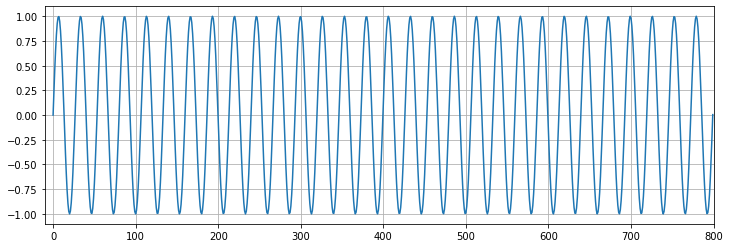

In [57]:
plt.figure(figsize=(12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(y.numpy());

# Hyper Parameters

In [58]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

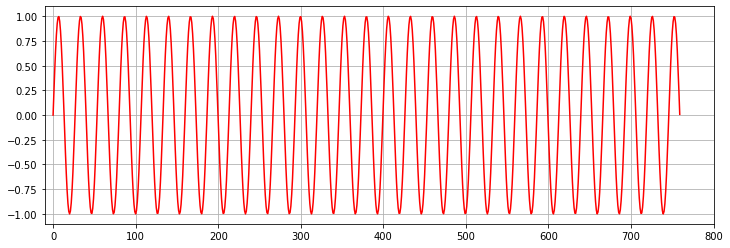

In [59]:
# Plot train set 
plt.figure(figsize=(12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(train_set.numpy(), 'r');

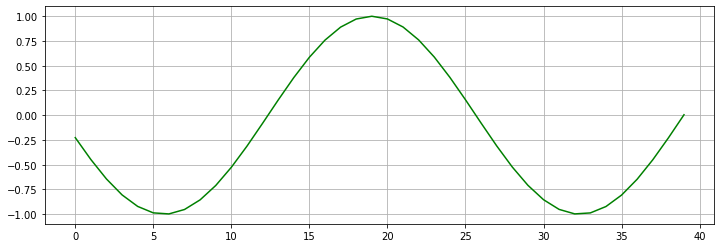

In [60]:
# Plot train set 
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(test_set.numpy(), 'green');

In [61]:
def input_data(seq, ws):

  out = [] # ([1,2,3,4],[5]), ([1,2,3,4,5],[6])

  L = len(seq)

  for i in range(L-ws):
    window = seq[i:i+ws]
    label = seq[i+ws:i+ws+1]

    out.append((window, label))


  return out

In [62]:
window_size = 40
train_data = input_data(train_set, window_size)

In [63]:
len(train_data)

720

# Build Model

In [64]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]   # we only care about the last prediction

# Evaluation Method

In [65]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Epoch:  1 Loss: 0.14985058
Loss on test predictions: 0.6406108140945435


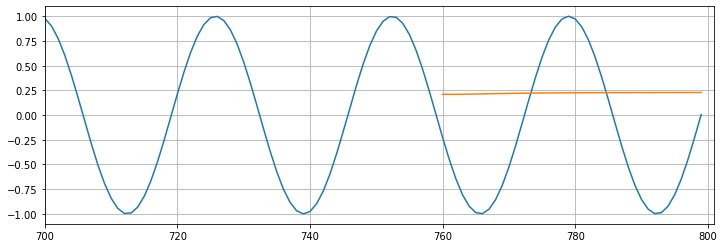

Epoch:  2 Loss: 0.08492811
Loss on test predictions: 0.5573228597640991


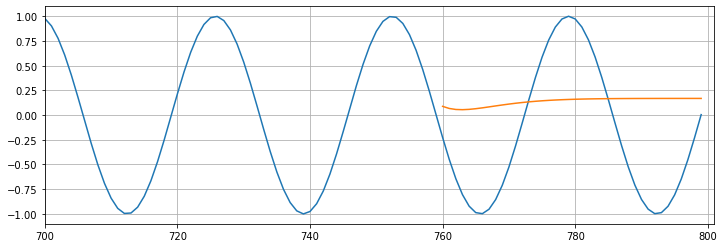

Epoch:  3 Loss: 0.01163555
Loss on test predictions: 0.2563738226890564


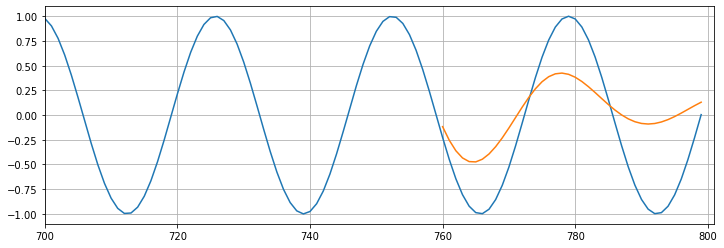

Epoch:  4 Loss: 0.00053331
Loss on test predictions: 0.0033028435427695513


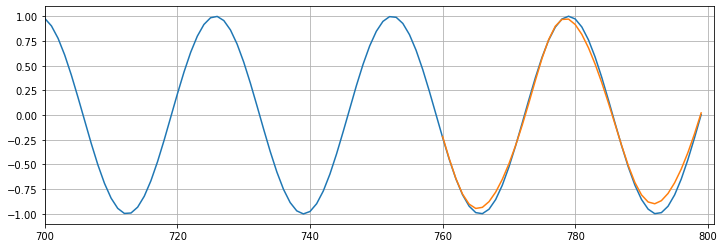

Epoch:  5 Loss: 0.00025803
Loss on test predictions: 0.0007812961121089756


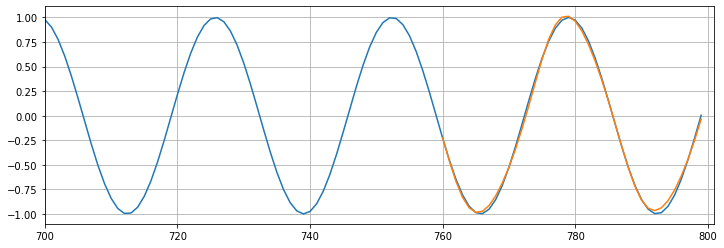

Epoch:  6 Loss: 0.00020937
Loss on test predictions: 0.0007067669066600502


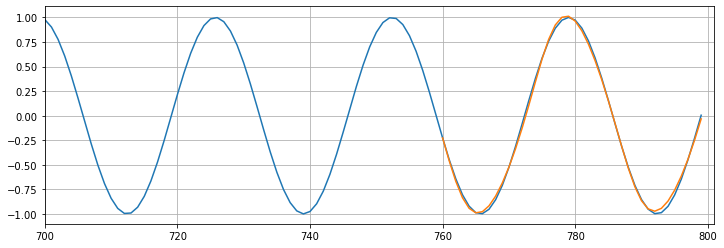

Epoch:  7 Loss: 0.00017922
Loss on test predictions: 0.0006703048711642623


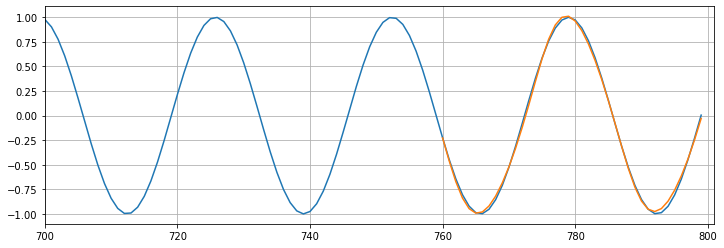

Epoch:  8 Loss: 0.00015740
Loss on test predictions: 0.0006447053165175021


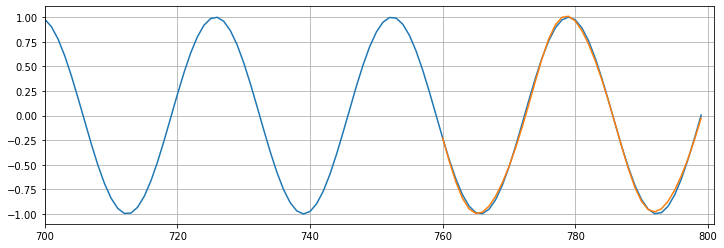

Epoch:  9 Loss: 0.00014112
Loss on test predictions: 0.00062593660550192


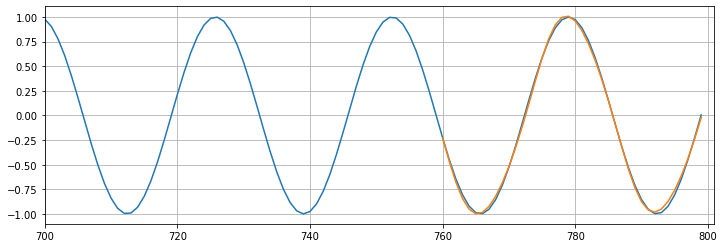

Epoch: 10 Loss: 0.00012868
Loss on test predictions: 0.0006119606550782919


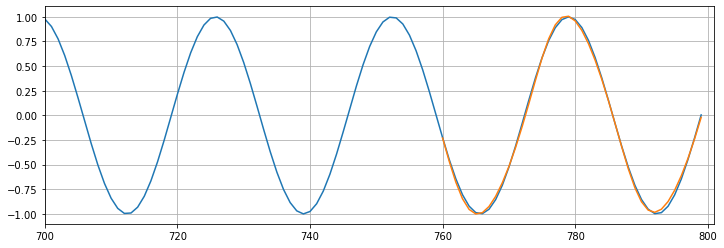

In [66]:
epochs = 10
future = 40

for i in range(epochs):
    
    # tuple-unpack the train_data set
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
    # MAKE PREDICTIONS
    # start with a list of the last 10 training records
    preds = train_set[-window_size:].tolist()

    for f in range(future):  
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Loss on test predictions: {loss}')

    # Plot from point 700 to the end
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

# Forecasting 

In [67]:
epochs = 10
window_size = 40
future = 40

# Create the full set of sequence/label tuples:
all_data = input_data(y,window_size)
len(all_data)  # this should equal 800-40

760

In [68]:
import time
start_time = time.time()

for i in range(epochs):
    
    # tuple-unpack the entire set of data
    for seq, y_train in all_data:  
       
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00013398
Epoch:  2 Loss: 0.00012776
Epoch:  3 Loss: 0.00012171
Epoch:  4 Loss: 0.00011576
Epoch:  5 Loss: 0.00011001
Epoch:  6 Loss: 0.00010452
Epoch:  7 Loss: 0.00009933
Epoch:  8 Loss: 0.00009444
Epoch:  9 Loss: 0.00008986
Epoch: 10 Loss: 0.00008558

Duration: 50 seconds


# Plot Unknown Data 

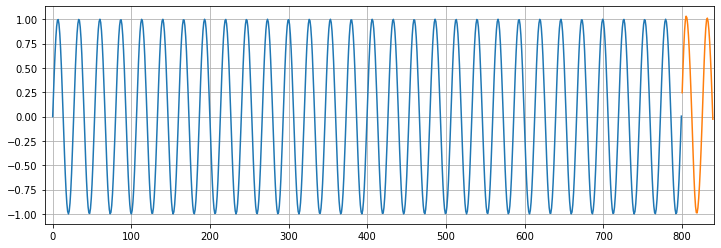

In [69]:
preds = y[-window_size:].tolist()

for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

plt.figure(figsize=(12,4))
plt.xlim(-10,841)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(800,800+future),preds[window_size:])
plt.show()